# ChIP-Seq analysis notebook

This interactive computational notebook is a template for analyzing ChIP-seq data preprocessed by BWA, MACS2, MEME, and MAST, performed by a companion upstream pipeline. 

To get started, put your processed pipeline outputs in the `data` folder.

## Setup the environment
Set the name of the experiment below. "E-1" is the name of the test experiment, using sample data from PPARGC1A ChIP-Seq in HepG2 generated by [Charos et al.](https://www.ncbi.nlm.nih.gov/pubmed/22955979)

In [1]:
expt_id = 'E-1'

Let's next load all the necessary libraries, and check that the data can be loaded.

In [2]:
# Load packages and set up notebook environment
options(warn = -1)
options(jupyter.plot_mimetypes = 'image/png')
suppressPackageStartupMessages(require(tidyverse))

Conflicts with tidy packages ---------------------------------------------------


In [3]:
# Load MACS2 peak data
fpath = paste0('../data/macs2_output/', expt_id, '_peaks.sorted.tsv')
peaks = read.csv(fpath, sep='\t', header=F, 
                 col.names=c('chrom', 'start', 'end', 'length', 'abs_summit', 'pileup', 
                             'log10p', 'fold_enrichment', 'log10q', 'name'))
head(peaks)

chrom,start,end,length,abs_summit,pileup,log10p,fold_enrichment,log10q,name
chr2,197499846,197500274,429,197500032,110.95,115.13895,22.38973,107.45395,E-1_peak_101
chr1,236097224,236097403,180,236097261,108.41,10.49074,1.98923,5.38763,E-1_peak_23
chr14,102086970,102087224,255,102087112,99.09,137.92659,38.31989,128.43541,E-1_peak_54
chr6,159789765,159789974,210,159789863,94.01,70.73698,11.87624,63.79480,E-1_peak_156
chr2,32916175,32916546,372,32916454,85.54,25.67412,3.93366,19.60472,E-1_peak_87
chr4,49710444,49711940,1497,49711480,84.69,39.33942,6.12097,32.88407,E-1_peak_135


## Histogram of peak scores
Stuart recommended two histogram plots as quality controls. The first displays the number of peaks by the peak score. Most peaks should have low scores, with a "long tail" of high-scoring peaks that represent the biologically relevant binding events.

This overall peak score histogram is plotted below.

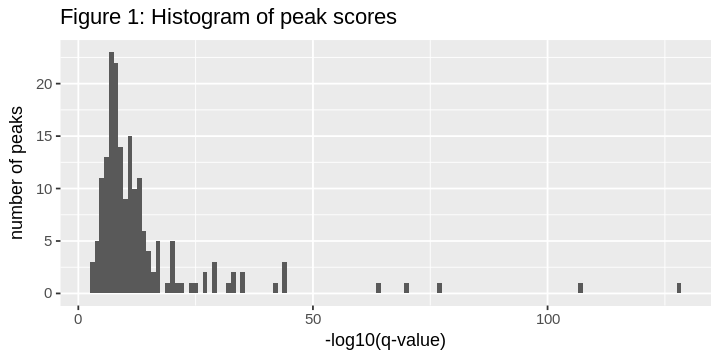

In [4]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(peaks, aes(x=log10q)) + geom_histogram(binwidth=1) + 
    ggtitle('Figure 1: Histogram of peak scores') +
    xlab('-log10(q-value)') + ylab('number of peaks')

## TSS coverage profiles
The ChIPseeker package (vignette [here] (http://bioconductor.org/packages/release/bioc/vignettes/ChIPseeker/inst/doc/ChIPseeker.html)
) was used to produce the ChIP-seq-specific plots below, such as a coverage heatmap relative to transcription start sites (TSS) across the genome, and to perform GO enrichment of nearby genes.

Load the packages and read the processed peaks. Peak processing was performed in the pipeline stage, following the steps recommended by Stuart:
- Filter blacklisted regions
- Filter non-canonical contigs (i.e., not chromosomes 1-22/X/Y/Mt) 
- Sort by coverage
- Extend by 100bp on each side
- Take top 300 peaks (by coverage)

In [5]:
suppressPackageStartupMessages(library('ChIPseeker'))
suppressPackageStartupMessages(library('TxDb.Hsapiens.UCSC.hg38.knownGene'))
suppressPackageStartupMessages(library('org.Hs.eg.db'))

In [6]:
peak <- readPeakFile('../data/macs2_output/E-1_peaks.sorted.filtered.extended.bed')
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

First, plot the peak coverage as a heatmap centered on promoter locations. This plot provides a granular view of all peak tags within 3kb of a promoter.

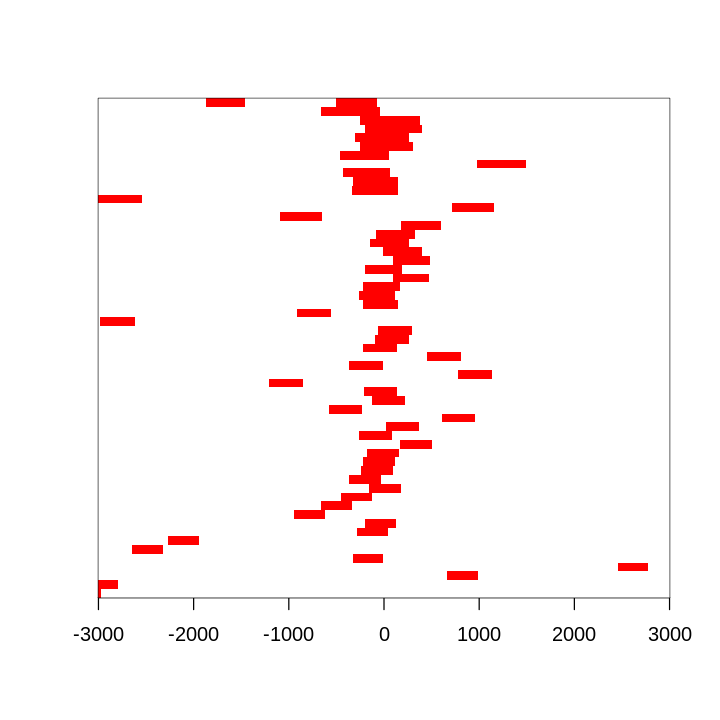

In [7]:
options(repr.plot.width=6, repr.plot.height=6)
promoter <- getPromoters(TxDb=txdb, upstream=3000, downstream=3000)
tagMatrix <- getTagMatrix(peak, windows=promoter)
tagHeatmap(tagMatrix, xlim=c(-3000, 3000), color="red")

The tag matrix (tag x position relative to promoter) can also be summarized by total coverage at each position.

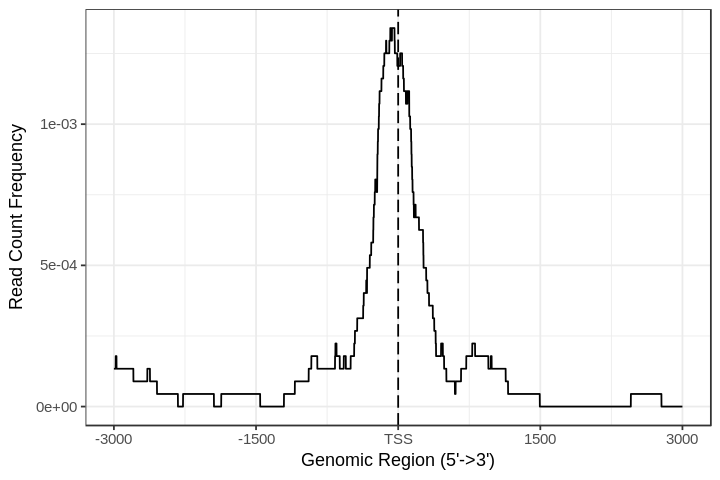

In [8]:
options(repr.plot.height=4, repr.plot.width=6)
plotAvgProf(tagMatrix, xlim=c(-3000, 3000),
            xlab="Genomic Region (5'->3')", ylab = "Read Count Frequency")

## Annotate genes and gene regions
Now that we know that binding sites are centered on promoters, as expected, we can search for patterns of enrichment in the gene annotations for these bound genes. ChIPseeker provides an annotation function using the EntrezGene (i.e., RefSeq) gene model to assign the nearest gene features to each peak.

In [9]:
peak_annots <- annotatePeak('../data/macs2_output/E-1_peaks.sorted.filtered.extended.bed', tssRegion=c(-3000, 3000),
                         TxDb=txdb, annoDb="org.Hs.eg.db")

>> loading peak file...				 2017-11-13 10:12:23 PM 
>> preparing features information...		 2017-11-13 10:12:23 PM 
>> identifying nearest features...		 2017-11-13 10:12:25 PM 
>> calculating distance from peak to TSS...	 2017-11-13 10:12:25 PM 
>> assigning genomic annotation...		 2017-11-13 10:12:25 PM 
>> adding gene annotation...			 2017-11-13 10:13:13 PM 


'select()' returned many:many mapping between keys and columns


>> assigning chromosome lengths			 2017-11-13 10:13:13 PM 
>> done...					 2017-11-13 10:13:13 PM 


The raw gene feature annotations can be viewed as a pie chart, showing the percentage of peaks landing on promoters, versus other gene features. As expected, promoters and intergenic regions are the dominant feature since this experiment uses transcription factors. This plot may be useful for characterizing the differences in binding patterns between TF and histones.

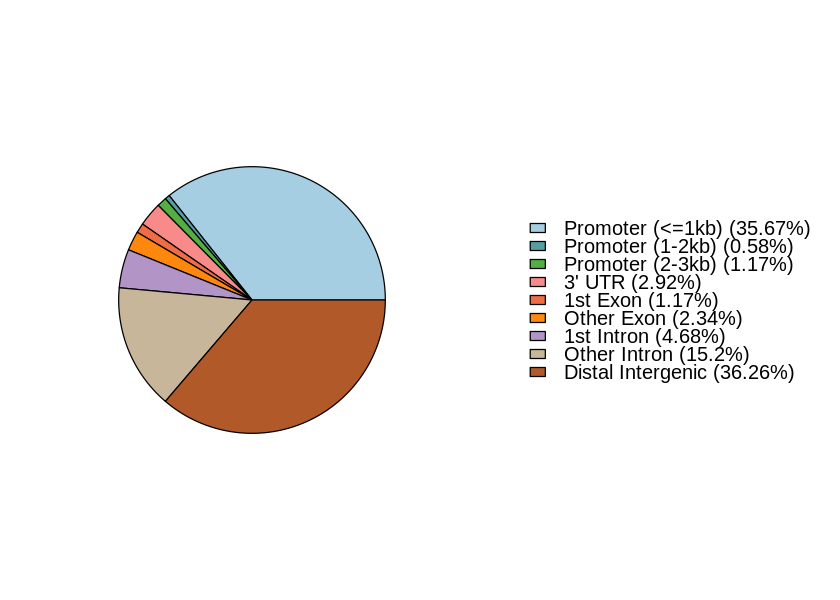

In [10]:
options(repr.plot.height=5, repr.plot.width=7)
plotAnnoPie(peak_annots)

The Gene Ontology annotations can be assigned and searched for enrichment in the group of bound genes, compared to their frequency in the genome. The [clusterProfiler](http://bioconductor.org/packages/release/bioc/vignettes/clusterProfiler/inst/doc/clusterProfiler.html)
package can generate enrichment scores from a list of Entrez Gene IDs derived from the peak annotation step.

In [11]:
# GO analysis using clusterProfiler
suppressPackageStartupMessages(library(clusterProfiler))
gene_ids <- as.data.frame(peak_annots)$geneId
gene <- bitr(gene_ids, fromType='ENTREZID', toType='SYMBOL', OrgDb='org.Hs.eg.db')


'select()' returned 1:1 mapping between keys and columns


First, we extract Biological Process (BP) annotations, which are generally the most informative. We can manually inspect the most frequently occurring annotations, but this will just give us the most general (therefore the most common) annotations, not the ones that are more common than expected.

In [12]:
ggo <- groupGO(gene     = gene_ids,
               OrgDb    = org.Hs.eg.db,
               ont      = "BP",
               level    = 3,
               readable = TRUE)
cat('Number of annotations')
nrow(ggo)
cat('Top annotation counts')
ggo %>% as.data.frame %>% arrange(desc(Count)) %>% head

Number of annotations

[1] 381

Top annotation counts

ID,Description,Count,GeneRatio,geneID
GO:0071704,organic substance metabolic process,94,94/164,HSPD1/HSP90AA1/MRPL18/CWH43/CWH43/USPL1/HSPA1B/HSP90AB1/HSPH1/TRIM24/CHORDC1/CCT4/MUM1/HSPA8/BMP7/DNAJB6/ATP5G3/PECR/FOXN4/HSPA1A/NEDD4L/DHRS2/HGSNAT/INPP5J/UBOX5/AHR/HSP90AB1/DNAJA1/UBB/AUH/KAT2A/HGSNAT/DCUN1D4/TRIM24/ARID1B/AANAT/SPR/CCL20/RAP2A/PROZ/EIF4EBP1/FBXO15/ATF7IP2/TGFBR2/LRIF1/ZNF337/MAPK4/TYW3/SPEN/CCT3/FAM83D/FOXJ1/POLR3E/CHFR/PPTC7/PCBD1/GXYLT2/RYBP/TRA2B/EFNA1/ST3GAL1/DGAT2/DHRS3/AKR1C4/DCUN1D4/NRIP1/RAD51B/USP44/CACYBP/ESRRA/NDUFB9/CCND3/ZNF184/HSD11B2/PGK2/SH3GLB1/ERI1/MRPS6/ZNF227/ZNF19/PARD3/SLC25A6/KHDRBS3/ORC3/PCSK1/CPE/SERPINA10/PGAM5/DEDD2/FKBP4/SERTAD2/NRIP1/ANK3/PRSS16
GO:0044237,cellular metabolic process,90,90/164,HSPD1/HSP90AA1/MRPL18/CWH43/CWH43/USPL1/HSPA1B/HSP90AB1/HSPH1/TRIM24/CHORDC1/CCT4/MUM1/HSPA8/BMP7/DNAJB6/ATP5G3/PECR/FOXN4/HSPA1A/NEDD4L/DHRS2/INPP5J/UBOX5/AHR/HSP90AB1/DNAJA1/UBB/AUH/KAT2A/DCUN1D4/TRIM24/ARID1B/NOX3/AANAT/SPR/CCL20/RAP2A/PROZ/EIF4EBP1/FBXO15/ATF7IP2/TGFBR2/LRIF1/ZNF337/MAPK4/TYW3/SPEN/CCT3/FAM83D/FOXJ1/POLR3E/CHFR/PPTC7/PCBD1/GXYLT2/RYBP/TRA2B/EFNA1/ST3GAL1/DGAT2/DHRS3/AKR1C4/DCUN1D4/NRIP1/RAD51B/USP44/CACYBP/ESRRA/NDUFB9/CCND3/ZNF184/PGK2/SH3GLB1/ERI1/MRPS6/ZNF227/ZNF19/PARD3/SLC25A6/KHDRBS3/ORC3/PCSK1/CPE/SERPINA10/PGAM5/DEDD2/FKBP4/SERTAD2/NRIP1
GO:0044238,primary metabolic process,89,89/164,HSPD1/HSP90AA1/MRPL18/CWH43/CWH43/USPL1/HSPA1B/HSP90AB1/HSPH1/TRIM24/CHORDC1/CCT4/MUM1/HSPA8/BMP7/DNAJB6/ATP5G3/PECR/FOXN4/HSPA1A/NEDD4L/DHRS2/INPP5J/UBOX5/AHR/HSP90AB1/DNAJA1/UBB/AUH/KAT2A/DCUN1D4/TRIM24/ARID1B/AANAT/CCL20/RAP2A/PROZ/EIF4EBP1/FBXO15/ATF7IP2/TGFBR2/LRIF1/ZNF337/MAPK4/TYW3/SPEN/CCT3/FAM83D/FOXJ1/POLR3E/CHFR/PPTC7/PCBD1/GXYLT2/RYBP/TRA2B/EFNA1/ST3GAL1/DGAT2/DHRS3/AKR1C4/DCUN1D4/NRIP1/RAD51B/USP44/CACYBP/ESRRA/NDUFB9/CCND3/ZNF184/HSD11B2/PGK2/ERI1/MRPS6/ZNF227/ZNF19/PARD3/SLC25A6/KHDRBS3/ORC3/PCSK1/CPE/SERPINA10/PGAM5/DEDD2/FKBP4/SERTAD2/NRIP1/PRSS16
GO:0044763,single-organism cellular process,83,83/164,HSPD1/NID1/HSP90AA1/MRPL18/CWH43/CWH43/HSPA1B/HSP90AB1/JPH4/HSPH1/TRIM24/CHORDC1/CCT4/HSPA8/BMP7/DNAJB6/ATP5G3/PECR/FOXN4/HSPA1A/NEDD4L/DHRS2/INPP5J/AHR/HSP90AB1/DNAJA1/ADGRF1/WDPCP/UBB/AUH/KAT2A/TRIM24/SCTR/CCL20/RAP2A/EIF4EBP1/ARHGEF28/TGFBR2/STARD13/MAPK4/SPEN/CCT3/FAM83D/FOXJ1/CHFR/PCBD1/ATRNL1/GXYLT2/RYBP/A1BG/EFNA1/ST3GAL1/AGR3/DGAT2/DHRS3/AKR1C4/UNC13B/SHROOM1/NRIP1/RAD51B/USP44/CACYBP/ESRRA/NDUFB9/CCND3/PGK2/SLCO4C1/CCR8/SH3GLB1/ERI1/MRPS6/PARD3/SLC25A6/ORC3/PCSK1/CPE/PGAM5/DEDD2/RPH3AL/FKBP4/SERTAD2/NRIP1/ANK3
GO:0050789,regulation of biological process,82,82/164,HSPD1/NID1/HSP90AA1/HSPA1B/HSP90AB1/JPH4/HSPH1/TRIM24/CHORDC1/CCT4/HSPA8/BMP7/DNAJB6/ST13/FOXN4/HSPA1A/NEDD4L/DHRS2/INPP5J/AHR/HSP90AB1/SNX5/DNAJA1/ADGRF1/WDPCP/UBB/KAT2A/DCUN1D4/TRIM24/ARID1B/SCTR/SPR/CCL20/RAP2A/EIF4EBP1/ATF7IP2/ARHGEF28/TGFBR2/STARD13/LRIF1/ZNF337/MAPK4/SPEN/CCT3/FAM83D/FOXJ1/POLR3E/CHFR/PCBD1/ATRNL1/RYBP/TRA2B/EFNA1/AGR3/DGAT2/DHRS3/UNC13B/DCUN1D4/NRIP1/RAD51B/USP44/CACYBP/ESRRA/CCND3/ZNF184/CCR8/SH3GLB1/ERI1/ZNF227/ZNF19/PARD3/SLC25A6/KHDRBS3/CPE/SERPINA10/PGAM5/DEDD2/RPH3AL/FKBP4/SERTAD2/NRIP1/ANK3
GO:0050794,regulation of cellular process,78,78/164,HSPD1/HSP90AA1/HSPA1B/HSP90AB1/JPH4/HSPH1/TRIM24/CHORDC1/CCT4/HSPA8/BMP7/DNAJB6/ST13/FOXN4/HSPA1A/NEDD4L/DHRS2/INPP5J/AHR/HSP90AB1/SNX5/DNAJA1/ADGRF1/WDPCP/UBB/KAT2A/DCUN1D4/TRIM24/ARID1B/SCTR/CCL20/RAP2A/EIF4EBP1/ATF7IP2/ARHGEF28/TGFBR2/STARD13/LRIF1/ZNF337/MAPK4/SPEN/CCT3/FAM83D/FOXJ1/CHFR/PCBD1/ATRNL1/RYBP/TRA2B/EFNA1/AGR3/DGAT2/DHRS3/UNC13B/DCUN1D4/NRIP1/RAD51B/USP44/CACYBP/ESRRA/CCND3/ZNF184/CCR8/SH3GLB1/ZNF227/ZNF19/PARD3/SLC25A6/KHDRBS3/CPE/SERPINA10/PGAM5/DEDD2/RPH3AL/FKBP4/SERTAD2/NRIP1/ANK3


More informative are enriched annotations. We can use enrichGO to find which of these annotations are statistically significant by the hypergeometric test. Heat shock protein annotations bubble to the top, with highly significant q-values (i.e., Benjamini-Hochberg FDR adjusted p-values).

In [13]:
ego <- enrichGO(gene          = gene_ids,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                readable      = TRUE)
head(ego)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0006457,GO:0006457,protein folding,14/117,222/16672,5.011376e-10,1.144598e-06,1.081930e-06,HSPD1/HSP90AA1/HSPA1B/HSP90AB1/HSPH1/CHORDC1/CCT4/HSPA8/DNAJB6/ST13/HSPA1A/DNAJA1/CCT3/FKBP4,14
GO:1900034,GO:1900034,regulation of cellular response to heat,9/117,76/16672,2.905691e-09,3.318299e-06,3.136617e-06,HSP90AA1/HSPA1B/HSP90AB1/HSPH1/CHORDC1/HSPA8/DNAJB6/HSPA1A/FKBP4,9
GO:0042026,GO:0042026,protein refolding,6/117,22/16672,7.145949e-09,5.440449e-06,5.142576e-06,HSPD1/HSP90AA1/HSPA1B/HSPA8/ST13/HSPA1A,6
GO:0009408,GO:0009408,response to heat,11/117,153/16672,1.020150e-08,5.825057e-06,5.506125e-06,HSPD1/HSP90AA1/HSPA1B/HSP90AB1/HSPH1/CHORDC1/HSPA8/DNAJB6/HSPA1A/DNAJA1/FKBP4,11
GO:0031647,GO:0031647,regulation of protein stability,12/117,216/16672,3.825911e-08,1.747676e-05,1.651988e-05,HSPD1/HSP90AA1/HSPA1B/HSP90AB1/TRIM24/CCT4/HSPA8/HSPA1A/KAT2A/CCT3/CHFR/SH3GLB1,12
GO:0034605,GO:0034605,cellular response to heat,9/117,108/16672,6.616268e-08,2.518593e-05,2.380696e-05,HSP90AA1/HSPA1B/HSP90AB1/HSPH1/CHORDC1/HSPA8/DNAJB6/HSPA1A/FKBP4,9


## MAST motif quantification
As part of the results zipfile created by the pipeline, there is an html file of the MAST algorithm output. This algorithm uses the top motifs returned by MEME, and quantifies their occurrences (hits) in the raw alignments. 

Stuart recommended plotting the distribution of hit counts versus p-value of significance of the hit, for each motif. Here we parse the XML-formatted file provided by MAST, and extract the hit counts for each motif, numbered 0 to 2 (in the order displayed in the MEME report).

In [14]:
library(XML)
mast_xml <- xmlParse('../data/mast_output/mast.xml')

mast_xml_to_hits <- function(mast_xml) {
  data <- xmlToList(mast_xml)
  
  # Dig into the tree with rbind and lapply to extract a data.frame
  df <- 
    do.call('rbind', lapply(data$sequences, function(seq) {
      do.call('rbind', lapply(seq[names(seq) == 'seg'], function(seg) {
        do.call('rbind', lapply(seg[names(seg) == 'hit'], function(hit) {
          return(data.frame(
            motif=as.integer(hit['idx']), 
            pvalue=as.numeric(hit['pvalue'])
          ))
        }))
      }))
    }))
  
  rownames(df) <- NULL
  return(df)
}

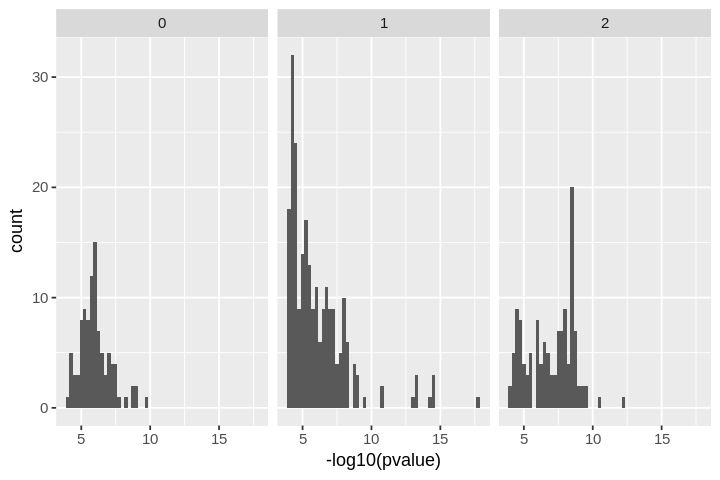

In [15]:
options(repr.plot.height=4, repr.plot.width=6)
df <- mast_xml_to_hits('../data/mast_output/mast.xml')
ggplot(df, aes(x=-log10(pvalue))) + geom_histogram(binwidth=0.25) + facet_wrap(~motif)